In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "kaabima" # username from the json file
os.environ['KAGGLE_KEY'] = "5c7f216ff1abf5cec9c8c005ca26ed9e" # key from the json file
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k # api copied from kaggle

 99% 1.24G/1.26G [00:41<00:00, 29.7MB/s]
100% 1.26G/1.26G [00:41<00:00, 32.5MB/s]


In [0]:
!mkdir ocular_diseases

In [0]:
!unzip ocular-disease-recognition-odir5k.zip -d ocular_diseases

In [0]:
!mv ocular_diseases/ODIR-5K/'Training Images' ocular_diseases/ODIR-5K/'training_images'

In [86]:
!ls ocular_diseases/ODIR-5K/

 data.xlsx  'Testing Images'   training_images


In [87]:
len(os.listdir('/content/ocular_diseases/ODIR-5K/training_images'))

7000

In [61]:
!find -name '4690_right.jpg'

./ocular_diseases/ODIR-5K/training_images/4690_right.jpg


In [0]:
import tensorflow as tf
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd
import numpy as np
from shutil import copyfile

In [0]:
data_excel = pd.read_excel('./ocular_diseases/ODIR-5K/data.xlsx')

In [8]:
data_excel.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [0]:
data_excel.columns = ['id', 'patient_age', 'patient_sex', 'left_fundus', 'right_fundus',
       'left_diagnostic', 'right_diagnostic', 'n', 'd', 'g',
       'c', 'a', 'h', 'm', 'o']

In [10]:
data_excel.head()

,id,patient_age,patient_sex,left_fundus,right_fundus,left_diagnostic,right_diagnostic,n,d,g,c,a,h,m,o
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [0]:
data_excel['sum_diseases'] = data_excel[['n', 'd', 'g',
       'c', 'a', 'h', 'm', 'o']].sum(axis = 1)

In [12]:
data_excel.head()

,id,patient_age,patient_sex,left_fundus,right_fundus,left_diagnostic,right_diagnostic,n,d,g,c,a,h,m,o,sum_diseases
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,1
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,2
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,2


In [13]:
data_excel.sum_diseases.unique()

array([1, 2, 3])

In [0]:
# len(os.listdir('./ocular_diseases/ODIR-5K/training_images'))

7000

In [0]:
kelas_dict = {
    0: 'normal',
    1: 'diabetes',
    2: 'glaucoma',
    3: 'cataract',
    4: 'amd',
    5: 'hypertension',
    6: 'myopia',
    7: 'abnormalities',
}

In [0]:
data_excel['kelas'] = data_excel.apply(lambda row: kelas_dict[np.argmax([row['n'], row['d'], row['g'], row['c'], row['a'], row['h'], row['m'], row['o']])], axis = 1)

In [0]:
df_1 = data_excel[data_excel.sum_diseases == 1]
df_2 = data_excel[data_excel.sum_diseases == 2]
df_3 = data_excel[data_excel.sum_diseases == 3]

In [46]:
df_1[(df_1.left_fundus == '4690_right.jpg') | (df_1.right_fundus == '4690_right.jpg')]

,id,patient_age,patient_sex,left_fundus,right_fundus,left_diagnostic,right_diagnostic,n,d,g,c,a,h,m,o,sum_diseases,kelas,tuple_class_left,tuple_class_right
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,1,diabetes,"(4690_left.jpg, diabetes)","(4690_right.jpg, diabetes)"


In [19]:
df_1['left_diagnostic'] = df_1['left_diagnostic'].str.replace('normal fundus', 'normal')
df_1['right_diagnostic'] = df_1['right_diagnostic'].str.replace('normal fundus', 'normal')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
df_1['tuple_class_left'] = df_1.apply(lambda row: (row['left_fundus'], row['left_diagnostic']) if row['left_diagnostic'] == 'normal' \
                               else (row['left_fundus'], row['kelas']), axis = 1)
df_1['tuple_class_right'] = df_1.apply(lambda row: (row['right_fundus'], row['right_diagnostic']) if row['right_diagnostic'] == 'normal' \
                               else (row['right_fundus'], row['kelas']), axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# df_1

In [0]:
# df_2

In [0]:
# df_3

In [0]:
# data_excel[data_excel.left_fundus == '1002_left.jpg']

In [0]:
# mata_kiri = {left_fundus: kelas for _, _, _, _, left_fundus, _, _, _, _, _, _, _, _, _, _, _, kelas in data_excel.itertuples()}

In [0]:
# mata_kiri

In [0]:
# mata_kanan = {right_fundus: kelas for _, _, _, _, _, right_fundus, _, _, _, _, _, _, _, _, _, _, kelas in data_excel.itertuples()}

In [0]:
# mata_kanan

In [79]:
!ls -al

total 1316120
drwxr-xr-x 1 root root       4096 Jun  6 04:45 .
drwxr-xr-x 1 root root       4096 Jun  6 01:19 ..
drwxr-xr-x 1 root root       4096 Jun  2 16:14 .config
-rw-r--r-- 1 root root 1347683678 Jun  6 01:22 ocular-disease-recognition-odir5k.zip
drwxr-xr-x 1 root root       4096 May 29 18:19 sample_data


In [0]:
kelas_dict = {
    0: 'normal',
    1: 'diabetes',
    2: 'glaucoma',
    3: 'cataract',
    4: 'amd',
    5: 'hypertension',
    6: 'myopia',
    7: 'abnormalities',
}

try:
    #YOUR CODE GOES HERE
    os.mkdir('/tmp/ocular/')
    os.mkdir('/tmp/ocular/training/')
    os.mkdir('/tmp/ocular/testing/')
    os.mkdir('/tmp/ocular/training/normal/')
    os.mkdir('/tmp/ocular/training/diabetes/')
    os.mkdir('/tmp/ocular/training/glaucoma/')
    os.mkdir('/tmp/ocular/training/cataract/')
    os.mkdir('/tmp/ocular/training/amd/')
    os.mkdir('/tmp/ocular/training/hypertension/')
    os.mkdir('/tmp/ocular/training/myopia/')
    os.mkdir('/tmp/ocular/training/abnormalities/')
    os.mkdir('/tmp/ocular/testing/normal/')
    os.mkdir('/tmp/ocular/testing/diabetes/')
    os.mkdir('/tmp/ocular/testing/glaucoma/')
    os.mkdir('/tmp/ocular/testing/cataract/')
    os.mkdir('/tmp/ocular/testing/amd/')
    os.mkdir('/tmp/ocular/testing/hypertension/')
    os.mkdir('/tmp/ocular/testing/myopia/')
    os.mkdir('/tmp/ocular/testing/abnormalities/')
except OSError:
    pass

In [91]:
# !rm -rf /tmp/ocular
!ls -al /tmp/ocular

total 16
drwxr-xr-x  4 root root 4096 Jun  6 04:48 .
drwxrwxrwt  1 root root 4096 Jun  6 04:48 ..
drwxr-xr-x 10 root root 4096 Jun  6 04:48 testing
drwxr-xr-x 10 root root 4096 Jun  6 04:48 training


In [64]:
print(len(df_1.tuple_class_left.to_numpy()))
print(len(df_1.tuple_class_right.to_numpy()))

2914
2914


In [66]:
print(len(df_1.tuple_class_left.to_list() + df_1.tuple_class_right.to_list()))

5828


In [0]:
import numpy as np

In [0]:
concat_training = np.array(df_1.tuple_class_left.to_list() + df_1.tuple_class_right.to_list())

In [73]:
concat_training

array([['2800_right.jpg', 'normal'],
       ['366_left.jpg', 'abnormalities'],
       ['556_right.jpg', 'diabetes'],
       ...,
       ['985_right.jpg', 'abnormalities'],
       ['102_right.jpg', 'amd'],
       ['2791_right.jpg', 'normal']], dtype='<U14')

In [0]:
np.random.shuffle(concat_training)

In [98]:
int(np.round(len(concat_training) * .8))

4662

In [99]:
def split_data(concat_train, source_dir, train_dir, test_dir, split_value=.8):
    print('Copying training files...')
    len_train = int(np.round(len(concat_training) * split_value))
    for img, cls in concat_train[:len_train]:
        copyfile(source_dir + '/' + img, train_dir + '/' + cls + '/' + img)
    print('Copying training files has finished!')
    
    print('Copying testing files...')
    for img, cls in concat_train[len_train:]:
        copyfile(source_dir + '/' + img, test_dir + '/' + cls + '/' + img)       
    print('Copying testing files has finished!')
    # YOUR CODE ENDS HERE

SOURCE_DIR = './ocular_diseases/ODIR-5K/training_images'
TRAINING_DIR = '/tmp/ocular/training'
TESTING_DIR = '/tmp/ocular/testing' 

split_data(concat_train=concat_training,
           source_dir=SOURCE_DIR,
           train_dir = TRAINING_DIR,
           test_dir = TESTING_DIR)

Copying training files...
Copying training files has finished!
Copying testing files...
Copying testing files has finished!


In [0]:
# def split_data(SOURCE_TRAINING, DESTINATION_TRAINING, SOURCE_TESTING, DESTINATION_TESTING):
#     print('Copying training files...')
#     for img, cls in df_1.tuple_class_left:
#         copyfile(SOURCE_TRAINING + '/' + img, DESTINATION_TRAINING + '/' + cls + '/' + img)

#     for img, cls in df_1.tuple_class_right:
#         copyfile(SOURCE_TRAINING + '/' + img, DESTINATION_TRAINING + '/' + cls + '/' + img)       
#     print('Copying training files has finished!')
    
#     print('Copying testing files...')
#     for img, cls in df_1.tuple_class_left:
#         try:
#             print(img, cls)
#             copyfile(SOURCE_TESTING + '/' + img, DESTINATION_TESTING + '/' + cls + '/' + img)
#         except:
#             continue

#     for img, cls in df_1.tuple_class_right:
#         try:
#             print(img, cls)
#             copyfile(SOURCE_TESTING + '/' + img, DESTINATION_TESTING + '/' + cls + '/' + img)
#         except:
#             continue
#     print('Copying testing files has finished!')
#     # YOUR CODE ENDS HERE

# SOURCE_TRAINING_DIR = './ocular_diseases/ODIR-5K/training_images'
# SOURCE_TESTING_DIR = '/ocular_diseases/ODIR-5K/testing_images'
# DESTINATION_TRAINING_DIR = '/tmp/ocular/training'
# DESTINATION_TESTING_DIR = '/tmp/ocular/testing' 

# split_data(SOURCE_TRAINING_DIR, DESTINATION_TRAINING_DIR, SOURCE_TESTING_DIR, DESTINATION_TESTING_DIR)

In [0]:
# len(os.listdir('/tmp/ocular/testing/diabetes/'))

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [100]:
# Define our example directories and files
base_dir = '/tmp/ocular/'

train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'testing')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 50,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 50,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 4662 images belonging to 8 classes.
Found 1166 images belonging to 8 classes.


In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['AUC', 'accuracy'])

# copyan

In [0]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=200,  # 2000 images = batch_size * steps
#       epochs=10,
#       validation_data=validation_generator,
#       validation_steps=50,  # 1000 images = batch_size * steps
#       verbose=2)

NameError: ignored

# lanjuut

In [111]:
history = model.fit(
      train_generator,
      validation_data = validation_generator,
      # steps_per_epoch=128,  # ~5828 images = batch_size * steps
      epochs=30,
      verbose=2)

Epoch 1/30
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94/94 - 272s - loss: 1.5214 - auc: 0.8249 - accuracy: 0.4983 - val_loss: 1.4657 - val_auc: 0.8409 - val_accuracy: 0.4871
Epoch 2/30
94/94 - 271s - loss: 1.4373 - auc: 0.8454 - accuracy: 0.5103 - val_loss: 1.4100 - val_auc: 0.8541 - val_accuracy: 0.5257
Epoch 3/30
94/94 - 270s - loss: 1.4014 - auc: 0.8553 - accuracy: 0.5150 - val_loss: 1.3561 - val_auc: 0.8664 - val_accuracy: 0.5283
Epoch 4/30
94/94 - 270s - loss: 1.3615 - auc: 0.8647 - accuracy: 0.5234 - val_loss: 1.3451 - val_auc: 0.8709 - val_accuracy: 0.5326
Epoch 5/30
94/94 - 269s - loss: 1.3150 - auc: 0.8747 - accuracy: 0.5270 - val_loss: 1.2961 - val_auc: 0.8791 - val_accuracy: 0.5360
Epoch 6/30
94/94 - 268s - loss: 1.2716 - auc: 0.8831 - accuracy: 0.5290 - val_loss: 1.2824 - val_auc: 0.8817 - val_accuracy: 0.5429
Epoch 7/30
94/94 - 269s - loss: 1.2335 - auc: 0.8902 - accuracy: 0.5412 - val_loss: 1.2678 - val_auc: 0.8837 - val_accuracy: 0.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

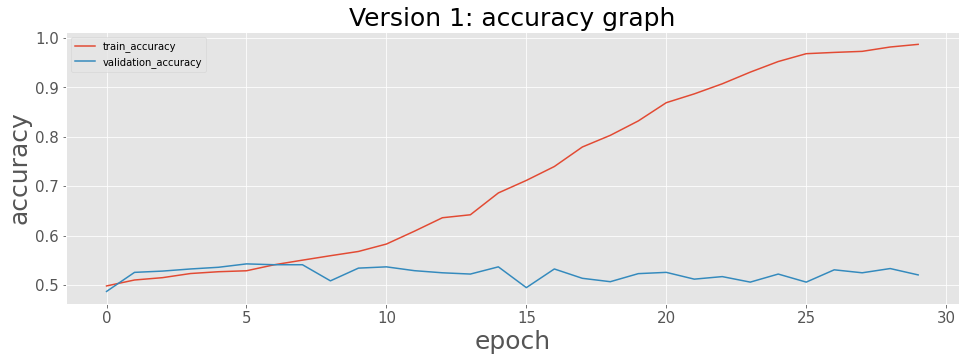

In [115]:
# acc
plt.figure(figsize=(16,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Version 1: accuracy graph', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.xlabel('epoch', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left', fontsize=10)
plt.savefig('./acc.jpg', dpi=300, quality=100)
plt.show()

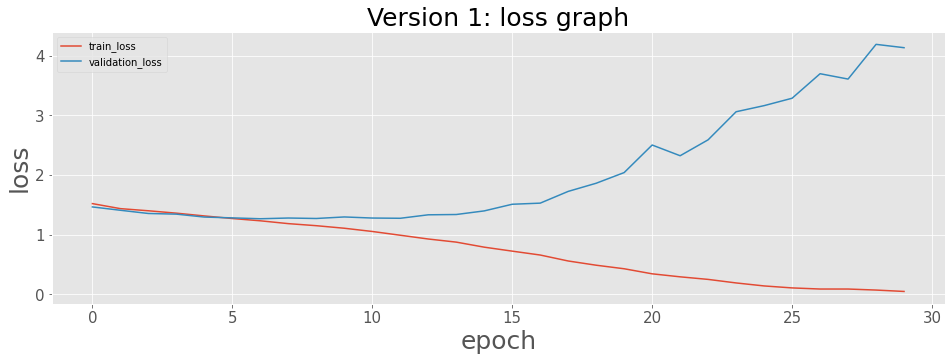

In [118]:
# loss
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Version 1: loss graph', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.xlabel('epoch', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['train_loss', 'validation_loss'], loc='upper left', fontsize=10)
plt.savefig('./loss.jpg', dpi=300, quality=100)
plt.show()

In [0]:
tf.keras.backend.clear_session()